In this notebook, we'll create a framework for image classification in Tensorflow.

This code should be replicable to any image task with a few changes.

Our specific task will be to classify images of traffic lights as red, yellow, or green.

In [6]:
#!/usr/bin/python2

%matplotlib inline

import sys, os, time
import itertools
import math, random
import glob
import tensorflow as tf
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

First, we set some basic parameters:

    base_image_path: the path where our training data is stored
    
    image_types: subdirectories in the images folder, each one representing a different class
    
    input_img_x/y: width and height of the images
    
    train_test_split_ratio: the ratio of training images to testing images
    
    batch_size: the minibatch size
    
    checkpoint_name: where we will save our best model
    

In [7]:
# Basic parameters

max_epochs = 25
base_image_path = "Dataset/"
image_types = ["30_SIGN", 
               "50_SIGN", 
               "60_SIGN", 
               "70_SIGN", 
               "80_SIGN", 
               "90_SIGN", 
               "100_SIGN", 
               "110_SIGN", 
               "120_SIGN",
               "GIVE_WAY",
               "NO_PARKING",
               "NO_STOPPING_NO_STANDING",
               "PASS_EITHER_SIDE",
               "PASS_LEFT_SIDE",
               "PASS_RIGHT_SIDE",
               "PEDESTRIAN_CROSSING",
               "PRIORITY_ROAD",
               "STOP"]
input_img_x = 32
input_img_y = 32
train_test_split_ratio = 0.9
batch_size = 32
checkpoint_name = "model.ckpt"

In [8]:
# Helper layer functions
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


Here we initialize our input and output neurons.

Our input neurons will be the shape of the image which is (32 x 32 x 3)

Because our data will be one-hot encoded, we have as many output neurons as we have classes

In [9]:
# Model

x = tf.placeholder(tf.float32, shape=[None, input_img_x, input_img_y, 3])
y_ = tf.placeholder(tf.float32, shape=[None, len(image_types)])

This is where we specify our first convolutional layers.

We specify the number of weights in the first line:

    W_conv1 = weight_variable([3, 3, 3, 16])
    
This line is for specifying the number of bias variables, or the variables that will be added to weights after multiplying them by the activation.

    b_conv1 = bias_variable([16])
    
Next, we specify the activation:

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 1) + b_conv1)

In [10]:
x_image = x

# Our first three convolutional layers, of 16 3x3 filters
W_conv1 = weight_variable([3, 3, 3, 16])
b_conv1 = bias_variable([16])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Our pooling layer


W_conv2 = weight_variable([3, 3, 16, 32])
b_conv2 = bias_variable([32])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, 1) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_conv3 = weight_variable([3, 3, 32, 64])
b_conv3 = bias_variable([64])
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3, 1) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)


n1, n2, n3, n4 = h_pool3.get_shape().as_list()


W_fc1 = weight_variable([n2*n3*n4, 18])
b_fc1 = bias_variable([18])


# We flatten our pool layer into a fully connected layer

h_pool4_flat = tf.reshape(h_pool3, [-1, n2*n3*n4])

y = tf.matmul(h_pool4_flat, W_fc1) + b_fc1

saver = tf.train.Saver({'W_conv1' : W_conv1, 'b_conv1' : b_conv1, 'W_fc1' : W_fc1, 'b_fc1' : b_fc1})


In [11]:
sess = tf.InteractiveSession()

Our loss function is defined as computing softmax, and then cross entropy.

We also specify our optimizer, which takes a learning rate, and a loss function.

Finally, we initialize all of our variables which will tell us if our model is valid.

In [12]:
# Our loss function and optimizer

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits = y))
train_step = tf.train.AdamOptimizer(1e-4, 0.9).minimize(loss)
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


We need to load in our images.  We do so using OpenCV's imread function.  After loading in each image, we resize it to our input size.

With each loaded image, we also specify the expected output.  For this, we use a one-hot encoding, creating an array of zeros represnting each class, and setting the index of the expected class number to 1.

For example, if we have three classes, and we expect an order of: [red neuron, green neuron, yellow neuron]

We initialize an array to [0, 0, 0] and if we loaded a yellow light, we change the last value to 1: [0, 0, 1]

Finally, we shuffle our dataset.  (It's generally useful to seed our random generator with 0 at the start of the program)

In [13]:
v_loss = least_loss = 99999999

# Load data

full_set = []

for im_type in image_types:
    for ex in glob.glob(os.path.join(base_image_path, im_type, "*")):
        im = cv2.imread(ex)
        if not im is None:
            im = cv2.resize(im, (32, 32))

            # Create an array representing our classes and set it
            one_hot_array = [0] * len(image_types)
            one_hot_array[image_types.index(im_type)] = 1

            assert(im.shape == (32, 32, 3))

            full_set.append((im, one_hot_array, ex))

random.shuffle(full_set)


Using our train_test_split_ratio we create two lists of examples: testing and training.

In [14]:
# We split our data into a training and test set here

split_index = int(math.floor(len(full_set) * train_test_split_ratio))
train_set = full_set[:split_index]
test_set = full_set[split_index:]

# We ensure that our training and test sets are a multiple of batch size
train_set_offset = len(train_set) % batch_size
test_set_offset = len(test_set) % batch_size
train_set = train_set[: len(train_set) - train_set_offset]
test_set = test_set[: len(test_set) - test_set_offset]

train_x, train_y, train_z = zip(*train_set)
test_x, test_y, test_z = zip(*test_set)

Every time we iterate over all of our training examples, we have completed one epoch.  Generally, we should start with one epoch while debugging, and in practice many datasets will converge with less than 100 epochs.  It's something that needs to be explored with each dataset.

We split our training set into batches, which we train on in order.

We then use our entire datset to calculate training and validation loss.  These are the values we want to minimize, but it's important to pay attention to the interaction between them.  If training loss is going down, but validation is staying the same, it means we are overfitting our dataset: our network is becoming increasingly good at correctly classifying our training examples, but our network isn't generalizing to other examples outside the training set.

We save our model if the current model has the lowest validation seen in this training run.

In [15]:
print("Starting training... [{} training examples]".format(len(train_x)))

v_loss = 9999999
train_loss = []
val_loss = []

for i in range(0, max_epochs):

    # Iterate over our training set
    for tt in range(0, (len(train_x) // batch_size)):
        start_batch = batch_size * tt
        end_batch = batch_size * (tt + 1)
        train_step.run(feed_dict={x: train_x[start_batch:end_batch], y_: train_y[start_batch:end_batch]})
        ex_seen = "Current epoch, examples seen: {:20} / {} \r".format(tt * batch_size, len(train_x))
        sys.stdout.write(ex_seen.format(tt * batch_size))
        sys.stdout.flush()

    ex_seen = "Current epoch, examples seen: {:20} / {} \r".format((tt + 1) * batch_size, len(train_x))
    sys.stdout.write(ex_seen.format(tt * batch_size))
    sys.stdout.flush()

    t_loss = loss.eval(feed_dict={x: train_x, y_: train_y})
    v_loss = loss.eval(feed_dict={x: test_x, y_: test_y})
    
    train_loss.append(t_loss)
    val_loss.append(v_loss)

    sys.stdout.write("Epoch {:5}: loss: {:15.10f}, val. loss: {:15.10f}".format(i + 1, t_loss, v_loss))

    if v_loss < least_loss:
        sys.stdout.write(", saving new best model to {}".format(checkpoint_name))
        least_loss = v_loss
        filename = saver.save(sess, checkpoint_name)

    sys.stdout.write("\n")

Starting training... [32928 training examples]
Epoch     1: loss:    1.6658487320, val. loss:    1.6821310520, saving new best model to model.ckpt
Epoch     2: loss:    0.8132297993, val. loss:    0.8485127091, saving new best model to model.ckpt
Epoch     3: loss:    0.5159941316, val. loss:    0.5678346753, saving new best model to model.ckpt
Epoch     4: loss:    0.3678013682, val. loss:    0.4267327189, saving new best model to model.ckpt
Epoch     5: loss:    0.2750888765, val. loss:    0.3347023427, saving new best model to model.ckpt
Epoch     6: loss:    0.2130824029, val. loss:    0.2779303491, saving new best model to model.ckpt
Epoch     7: loss:    0.1560289413, val. loss:    0.2198448479, saving new best model to model.ckpt
Epoch     8: loss:    0.1346675456, val. loss:    0.1939036399, saving new best model to model.ckpt
Epoch     9: loss:    0.1004710272, val. loss:    0.1578459442, saving new best model to model.ckpt
Epoch    10: loss:    0.0952096730, val. loss:    0.1

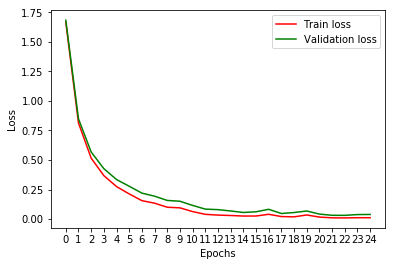

In [ ]:
plt.figure()
plt.xticks(np.arange(0, len(train_loss), 1.0))
plt.ylabel("Loss")
plt.xlabel("Epochs")
train_line = plt.plot(range(0, len(train_loss)), train_loss, 'r', label="Train loss")
val_line = plt.plot(range(0, len(val_loss)), val_loss, 'g', label="Validation loss")
plt.legend()
plt.show()

Let's print the examples from our test set that were wrong:

Accuracy = 1.000000, Time = 0.023079 sec
Slope = 21.664793
Accuracy = 1.000000, Time = 0.033652 sec
Slope = 14.858034
Accuracy = 1.000000, Time = 0.042707 sec
Slope = 11.707692
Accuracy = 1.000000, Time = 0.052430 sec
Slope = 9.536497
Accuracy = 1.000000, Time = 0.061825 sec
Slope = 8.087338
Accuracy = 1.000000, Time = 0.072177 sec
Slope = 6.927421
Accuracy = 1.000000, Time = 0.083419 sec
Slope = 5.993832
Accuracy = 1.000000, Time = 0.093815 sec
Slope = 5.329633
Accuracy = 1.000000, Time = 0.104623 sec
Slope = 4.779060
Accuracy = 1.000000, Time = 0.114428 sec
Slope = 4.369567
Accuracy = 1.000000, Time = 0.124251 sec
Slope = 4.024108
Accuracy = 1.000000, Time = 0.134267 sec
Slope = 3.723921
Accuracy = 1.000000, Time = 0.144561 sec
Slope = 3.458752
Accuracy = 1.000000, Time = 0.155311 sec
Slope = 3.219345
Accuracy = 1.000000, Time = 0.164986 sec
Slope = 3.030558
Accuracy = 1.000000, Time = 0.176539 sec
Slope = 2.832232
Accuracy = 1.000000, Time = 0.186420 sec
Slope = 2.682116
Actual: 90_

Accuracy = 1.000000, Time = 0.201953 sec
Slope = 2.475824
Accuracy = 1.000000, Time = 0.213216 sec
Slope = 2.345039
Accuracy = 1.000000, Time = 0.224338 sec
Slope = 2.228782
Accuracy = 1.000000, Time = 0.236605 sec
Slope = 2.113227
Accuracy = 1.000000, Time = 0.248049 sec
Slope = 2.015733
Accuracy = 1.000000, Time = 0.259530 sec
Slope = 1.926559
Accuracy = 1.000000, Time = 0.270272 sec
Slope = 1.849988
Accuracy = 1.000000, Time = 0.280780 sec
Slope = 1.780753
Accuracy = 1.000000, Time = 0.291640 sec
Slope = 1.714442
Accuracy = 1.000000, Time = 0.302380 sec
Slope = 1.653548
Accuracy = 1.000000, Time = 0.313041 sec
Slope = 1.597235
Accuracy = 1.000000, Time = 0.323871 sec
Slope = 1.543825
Accuracy = 1.000000, Time = 0.334751 sec
Slope = 1.493648
Accuracy = 1.000000, Time = 0.345463 sec
Slope = 1.447333
Accuracy = 1.000000, Time = 0.356250 sec
Slope = 1.403509
Accuracy = 1.000000, Time = 0.367111 sec
Slope = 1.361986
Accuracy = 1.000000, Time = 0.378081 sec
Slope = 1.322468
Accuracy = 1.0

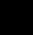

Accuracy = 1.000000, Time = 0.719637 sec
Slope = 0.694795
Accuracy = 1.000000, Time = 0.732447 sec
Slope = 0.682643
Accuracy = 1.000000, Time = 0.750426 sec
Slope = 0.666288
Accuracy = 1.000000, Time = 0.762834 sec
Slope = 0.655451
Accuracy = 1.000000, Time = 0.774385 sec
Slope = 0.645674
Accuracy = 1.000000, Time = 0.786164 sec
Slope = 0.636000
Accuracy = 1.000000, Time = 0.798086 sec
Slope = 0.626499
Accuracy = 1.000000, Time = 0.810423 sec
Slope = 0.616962
Accuracy = 1.000000, Time = 0.822621 sec
Slope = 0.607813
Accuracy = 1.000000, Time = 0.838354 sec
Slope = 0.596407
Accuracy = 1.000000, Time = 0.852698 sec
Slope = 0.586374
Accuracy = 1.000000, Time = 0.865274 sec
Slope = 0.577852
Accuracy = 1.000000, Time = 0.878317 sec
Slope = 0.569270
Accuracy = 1.000000, Time = 0.891305 sec
Slope = 0.560975
Accuracy = 1.000000, Time = 0.903554 sec
Slope = 0.553370
Accuracy = 1.000000, Time = 0.916238 sec
Slope = 0.545710
Accuracy = 1.000000, Time = 0.929937 sec
Slope = 0.537671
Accuracy = 1.0

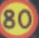

Accuracy = 1.000000, Time = 1.978445 sec
Slope = 0.252724
Accuracy = 1.000000, Time = 1.994537 sec
Slope = 0.250685
Accuracy = 1.000000, Time = 2.010818 sec
Slope = 0.248655
Accuracy = 1.000000, Time = 2.025713 sec
Slope = 0.246827
Accuracy = 1.000000, Time = 2.041976 sec
Slope = 0.244861
Accuracy = 1.000000, Time = 2.057827 sec
Slope = 0.242975
Accuracy = 1.000000, Time = 2.072677 sec
Slope = 0.241234
Accuracy = 1.000000, Time = 2.088140 sec
Slope = 0.239448
Accuracy = 1.000000, Time = 2.103598 sec
Slope = 0.237688
Accuracy = 1.000000, Time = 2.120208 sec
Slope = 0.235826
Accuracy = 1.000000, Time = 2.136769 sec
Slope = 0.233998
Accuracy = 1.000000, Time = 2.153539 sec
Slope = 0.232176
Accuracy = 1.000000, Time = 2.168797 sec
Slope = 0.230543
Accuracy = 1.000000, Time = 2.184100 sec
Slope = 0.228927
Accuracy = 1.000000, Time = 2.199495 sec
Slope = 0.227325
Accuracy = 1.000000, Time = 2.214928 sec
Slope = 0.225741
Accuracy = 1.000000, Time = 2.231109 sec
Slope = 0.224104
Accuracy = 1.0

Accuracy = 1.000000, Time = 4.103163 sec
Slope = 0.121857
Accuracy = 1.000000, Time = 4.122937 sec
Slope = 0.121273
Accuracy = 1.000000, Time = 4.142032 sec
Slope = 0.120714
Accuracy = 1.000000, Time = 4.160660 sec
Slope = 0.120173
Accuracy = 1.000000, Time = 4.179390 sec
Slope = 0.119635
Accuracy = 1.000000, Time = 4.198028 sec
Slope = 0.119104
Accuracy = 1.000000, Time = 4.216767 sec
Slope = 0.118574
Accuracy = 1.000000, Time = 4.234895 sec
Slope = 0.118067
Accuracy = 1.000000, Time = 4.253386 sec
Slope = 0.117553
Accuracy = 1.000000, Time = 4.273085 sec
Slope = 0.117011
Accuracy = 1.000000, Time = 4.291936 sec
Slope = 0.116498
Accuracy = 1.000000, Time = 4.311555 sec
Slope = 0.115967
Accuracy = 1.000000, Time = 4.331180 sec
Slope = 0.115442
Accuracy = 1.000000, Time = 4.351221 sec
Slope = 0.114910
Accuracy = 1.000000, Time = 4.369933 sec
Slope = 0.114418
Accuracy = 1.000000, Time = 4.388960 sec
Slope = 0.113922
Accuracy = 1.000000, Time = 4.407877 sec
Slope = 0.113433
Accuracy = 1.0

Accuracy = 1.000000, Time = 6.693608 sec
Slope = 0.074698
Accuracy = 1.000000, Time = 6.716709 sec
Slope = 0.074441
Accuracy = 1.000000, Time = 6.738652 sec
Slope = 0.074199
Accuracy = 1.000000, Time = 6.761204 sec
Slope = 0.073951
Accuracy = 1.000000, Time = 6.783461 sec
Slope = 0.073709
Accuracy = 1.000000, Time = 6.806069 sec
Slope = 0.073464
Accuracy = 1.000000, Time = 6.827889 sec
Slope = 0.073229
Accuracy = 1.000000, Time = 6.851580 sec
Slope = 0.072976
Accuracy = 1.000000, Time = 6.876550 sec
Slope = 0.072711
Accuracy = 1.000000, Time = 6.899283 sec
Slope = 0.072471
Accuracy = 1.000000, Time = 6.923614 sec
Slope = 0.072217
Accuracy = 1.000000, Time = 6.947088 sec
Slope = 0.071973
Accuracy = 1.000000, Time = 6.969576 sec
Slope = 0.071740
Accuracy = 1.000000, Time = 6.991085 sec
Slope = 0.071520
Accuracy = 1.000000, Time = 7.013218 sec
Slope = 0.071294
Accuracy = 1.000000, Time = 7.035791 sec
Slope = 0.071065
Accuracy = 1.000000, Time = 7.058534 sec
Slope = 0.070836
Accuracy = 1.0

Accuracy = 1.000000, Time = 10.357753 sec
Slope = 0.048273
Accuracy = 1.000000, Time = 10.388799 sec
Slope = 0.048129
Accuracy = 1.000000, Time = 10.419588 sec
Slope = 0.047987
Accuracy = 1.000000, Time = 10.446027 sec
Slope = 0.047865
Accuracy = 1.000000, Time = 10.473158 sec
Slope = 0.047741
Accuracy = 1.000000, Time = 10.500106 sec
Slope = 0.047619
Accuracy = 1.000000, Time = 10.528076 sec
Slope = 0.047492
Accuracy = 1.000000, Time = 10.554634 sec
Slope = 0.047373
Accuracy = 1.000000, Time = 10.583564 sec
Slope = 0.047243
Accuracy = 1.000000, Time = 10.614247 sec
Slope = 0.047106
Accuracy = 1.000000, Time = 10.641975 sec
Slope = 0.046984
Accuracy = 1.000000, Time = 10.669071 sec
Slope = 0.046864
Accuracy = 1.000000, Time = 10.698359 sec
Slope = 0.046736
Accuracy = 1.000000, Time = 10.726147 sec
Slope = 0.046615
Accuracy = 1.000000, Time = 10.753814 sec
Slope = 0.046495
Accuracy = 1.000000, Time = 10.781082 sec
Slope = 0.046378
Accuracy = 1.000000, Time = 10.808425 sec
Slope = 0.0462

Accuracy = 1.000000, Time = 11.203225 sec
Slope = 0.044630
Accuracy = 1.000000, Time = 11.231712 sec
Slope = 0.044517
Accuracy = 1.000000, Time = 11.259030 sec
Slope = 0.044409
Accuracy = 1.000000, Time = 11.285864 sec
Slope = 0.044303
Accuracy = 1.000000, Time = 11.315215 sec
Slope = 0.044188
Accuracy = 1.000000, Time = 11.344579 sec
Slope = 0.044074
Accuracy = 1.000000, Time = 11.373681 sec
Slope = 0.043961
Accuracy = 1.000000, Time = 11.402535 sec
Slope = 0.043850
Accuracy = 1.000000, Time = 11.433122 sec
Slope = 0.043733
Accuracy = 1.000000, Time = 11.462328 sec
Slope = 0.043621
Accuracy = 1.000000, Time = 11.489406 sec
Slope = 0.043518
Accuracy = 1.000000, Time = 11.520185 sec
Slope = 0.043402
Accuracy = 1.000000, Time = 11.548832 sec
Slope = 0.043294
Accuracy = 1.000000, Time = 11.578199 sec
Slope = 0.043185
Accuracy = 1.000000, Time = 11.607316 sec
Slope = 0.043076
Accuracy = 1.000000, Time = 11.636932 sec
Slope = 0.042967
Accuracy = 1.000000, Time = 11.666644 sec
Slope = 0.0428

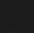

Accuracy = 1.000000, Time = 14.106412 sec
Slope = 0.035445
Accuracy = 1.000000, Time = 14.143274 sec
Slope = 0.035352
Accuracy = 1.000000, Time = 14.178493 sec
Slope = 0.035265
Accuracy = 1.000000, Time = 14.212117 sec
Slope = 0.035181
Accuracy = 1.000000, Time = 14.250008 sec
Slope = 0.035088
Accuracy = 1.000000, Time = 14.282384 sec
Slope = 0.035008
Accuracy = 1.000000, Time = 14.314269 sec
Slope = 0.034930
Accuracy = 1.000000, Time = 14.351049 sec
Slope = 0.034841
Accuracy = 1.000000, Time = 14.398114 sec
Slope = 0.034727
Accuracy = 1.000000, Time = 14.430874 sec
Slope = 0.034648
Accuracy = 1.000000, Time = 14.462549 sec
Slope = 0.034572
Accuracy = 1.000000, Time = 14.495612 sec
Slope = 0.034493
Accuracy = 1.000000, Time = 14.533269 sec
Slope = 0.034404
Accuracy = 1.000000, Time = 14.571878 sec
Slope = 0.034313
Accuracy = 1.000000, Time = 14.601721 sec
Slope = 0.034243
Accuracy = 1.000000, Time = 14.642236 sec
Slope = 0.034148
Accuracy = 1.000000, Time = 14.672491 sec
Slope = 0.0340

Accuracy = 1.000000, Time = 19.193465 sec
Slope = 0.026051
Accuracy = 1.000000, Time = 19.233961 sec
Slope = 0.025996
Accuracy = 1.000000, Time = 19.279638 sec
Slope = 0.025934
Accuracy = 1.000000, Time = 19.315789 sec
Slope = 0.025886
Accuracy = 1.000000, Time = 19.352516 sec
Slope = 0.025836
Accuracy = 1.000000, Time = 19.387358 sec
Slope = 0.025790
Actual: PASS_RIGHT_SIDE, predicted: PASS_LEFT_SIDE


Accuracy = 1.000000, Time = 19.434068 sec
Slope = 0.025728
Accuracy = 1.000000, Time = 19.472719 sec
Slope = 0.025677
Accuracy = 1.000000, Time = 19.508347 sec
Slope = 0.025630
Accuracy = 1.000000, Time = 19.544272 sec
Slope = 0.025583
Accuracy = 1.000000, Time = 19.581167 sec
Slope = 0.025535
Accuracy = 1.000000, Time = 19.617409 sec
Slope = 0.025488
Accuracy = 1.000000, Time = 19.657916 sec
Slope = 0.025435
Accuracy = 1.000000, Time = 19.694917 sec
Slope = 0.025387
Accuracy = 1.000000, Time = 19.733474 sec
Slope = 0.025338
Accuracy = 1.000000, Time = 19.769947 sec
Slope = 0.025291
Accuracy = 1.000000, Time = 19.806820 sec
Slope = 0.025244
Accuracy = 1.000000, Time = 19.844090 sec
Slope = 0.025196
800
Accuracy = 1.000000, Time = 19.885022 sec
Slope = 0.025145
Accuracy = 1.000000, Time = 19.922090 sec
Slope = 0.025098
Accuracy = 1.000000, Time = 19.959206 sec
Slope = 0.025051
Accuracy = 1.000000, Time = 19.996869 sec
Slope = 0.025004
Accuracy = 1.000000, Time = 20.031200 sec
Slope = 0.

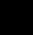

Accuracy = 1.000000, Time = 20.965586 sec
Slope = 0.023849
Accuracy = 1.000000, Time = 21.005421 sec
Slope = 0.023803
Accuracy = 1.000000, Time = 21.050923 sec
Slope = 0.023752
Accuracy = 1.000000, Time = 21.087261 sec
Slope = 0.023711
Accuracy = 1.000000, Time = 21.126119 sec
Slope = 0.023667
Accuracy = 1.000000, Time = 21.164363 sec
Slope = 0.023625
Accuracy = 1.000000, Time = 21.210219 sec
Slope = 0.023574
Accuracy = 1.000000, Time = 21.249317 sec
Slope = 0.023530
Accuracy = 1.000000, Time = 21.287671 sec
Slope = 0.023488
Accuracy = 1.000000, Time = 21.332132 sec
Slope = 0.023439
Accuracy = 1.000000, Time = 21.370217 sec
Slope = 0.023397
Accuracy = 1.000000, Time = 21.408020 sec
Slope = 0.023356
Accuracy = 1.000000, Time = 21.459997 sec
Slope = 0.023299
Accuracy = 1.000000, Time = 21.497665 sec
Slope = 0.023258
Accuracy = 1.000000, Time = 21.536390 sec
Slope = 0.023217
Accuracy = 1.000000, Time = 21.575267 sec
Slope = 0.023175
Accuracy = 1.000000, Time = 21.617988 sec
Slope = 0.0231

Accuracy = 1.000000, Time = 22.228029 sec
Slope = 0.022494
Accuracy = 1.000000, Time = 22.267144 sec
Slope = 0.022455
Accuracy = 1.000000, Time = 22.307592 sec
Slope = 0.022414
Accuracy = 1.000000, Time = 22.346873 sec
Slope = 0.022374
Accuracy = 1.000000, Time = 22.386913 sec
Slope = 0.022334
Accuracy = 1.000000, Time = 22.427386 sec
Slope = 0.022294
Accuracy = 1.000000, Time = 22.468802 sec
Slope = 0.022253
Accuracy = 1.000000, Time = 22.518285 sec
Slope = 0.022204
Accuracy = 1.000000, Time = 22.559435 sec
Slope = 0.022164
Accuracy = 1.000000, Time = 22.598508 sec
Slope = 0.022125
Accuracy = 1.000000, Time = 22.639114 sec
Slope = 0.022086
Accuracy = 1.000000, Time = 22.682894 sec
Slope = 0.022043
Accuracy = 1.000000, Time = 22.727895 sec
Slope = 0.021999
Accuracy = 1.000000, Time = 22.768112 sec
Slope = 0.021961
Accuracy = 1.000000, Time = 22.808909 sec
Slope = 0.021921
Accuracy = 1.000000, Time = 22.849750 sec
Slope = 0.021882
Accuracy = 1.000000, Time = 22.896986 sec
Slope = 0.0218

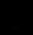

Accuracy = 1.000000, Time = 24.851826 sec
Slope = 0.020119
Accuracy = 1.000000, Time = 24.896811 sec
Slope = 0.020083
Accuracy = 1.000000, Time = 24.937949 sec
Slope = 0.020050
Accuracy = 1.000000, Time = 24.978334 sec
Slope = 0.020017
Accuracy = 1.000000, Time = 25.016571 sec
Slope = 0.019987
Accuracy = 1.000000, Time = 25.059205 sec
Slope = 0.019953
Accuracy = 1.000000, Time = 25.110828 sec
Slope = 0.019912
Accuracy = 1.000000, Time = 25.153214 sec
Slope = 0.019878
Accuracy = 1.000000, Time = 25.195277 sec
Slope = 0.019845
Accuracy = 1.000000, Time = 25.240014 sec
Slope = 0.019810
Accuracy = 1.000000, Time = 25.282932 sec
Slope = 0.019776
Accuracy = 1.000000, Time = 25.325916 sec
Slope = 0.019743
Accuracy = 1.000000, Time = 25.368564 sec
Slope = 0.019709
Accuracy = 1.000000, Time = 25.413848 sec
Slope = 0.019674
Accuracy = 1.000000, Time = 25.457342 sec
Slope = 0.019641
Accuracy = 1.000000, Time = 25.498131 sec
Slope = 0.019609
Accuracy = 1.000000, Time = 25.539449 sec
Slope = 0.0195

Accuracy = 1.000000, Time = 31.204779 sec
Slope = 0.016023
Accuracy = 1.000000, Time = 31.251707 sec
Slope = 0.015999
Accuracy = 1.000000, Time = 31.295263 sec
Slope = 0.015977
Accuracy = 1.000000, Time = 31.341825 sec
Slope = 0.015953
Accuracy = 1.000000, Time = 31.388454 sec
Slope = 0.015929
Accuracy = 1.000000, Time = 31.438510 sec
Slope = 0.015904
Accuracy = 1.000000, Time = 31.483441 sec
Slope = 0.015881
Accuracy = 1.000000, Time = 31.528246 sec
Slope = 0.015859
Accuracy = 1.000000, Time = 31.573349 sec
Slope = 0.015836
Accuracy = 1.000000, Time = 31.621225 sec
Slope = 0.015812
Accuracy = 1.000000, Time = 31.670905 sec
Slope = 0.015787
Accuracy = 1.000000, Time = 31.718253 sec
Slope = 0.015764
Accuracy = 1.000000, Time = 31.763896 sec
Slope = 0.015741
Accuracy = 1.000000, Time = 31.812394 sec
Slope = 0.015717
Accuracy = 1.000000, Time = 31.859246 sec
Slope = 0.015694
Accuracy = 1.000000, Time = 31.910304 sec
Slope = 0.015669
Accuracy = 1.000000, Time = 31.957413 sec
Slope = 0.0156

Accuracy = 1.000000, Time = 34.647726 sec
Slope = 0.014431
Accuracy = 1.000000, Time = 34.700437 sec
Slope = 0.014409
Accuracy = 1.000000, Time = 34.750157 sec
Slope = 0.014388
Accuracy = 1.000000, Time = 34.800366 sec
Slope = 0.014368
Accuracy = 1.000000, Time = 34.850455 sec
Slope = 0.014347
Accuracy = 1.000000, Time = 34.906156 sec
Slope = 0.014324
Accuracy = 1.000000, Time = 34.955843 sec
Slope = 0.014304
Accuracy = 1.000000, Time = 35.004214 sec
Slope = 0.014284
Accuracy = 1.000000, Time = 35.053043 sec
Slope = 0.014264
Accuracy = 1.000000, Time = 35.101728 sec
Slope = 0.014244
Accuracy = 1.000000, Time = 35.153108 sec
Slope = 0.014223
Accuracy = 1.000000, Time = 35.202858 sec
Slope = 0.014203
Accuracy = 1.000000, Time = 35.255030 sec
Slope = 0.014182
Accuracy = 1.000000, Time = 35.303198 sec
Slope = 0.014163
Accuracy = 1.000000, Time = 35.353058 sec
Slope = 0.014143
Accuracy = 1.000000, Time = 35.487479 sec
Slope = 0.014089
Accuracy = 1.000000, Time = 35.538731 sec
Slope = 0.0140

Accuracy = 1.000000, Time = 42.105681 sec
Slope = 0.011875
Accuracy = 1.000000, Time = 42.163493 sec
Slope = 0.011859
Accuracy = 1.000000, Time = 42.215073 sec
Slope = 0.011844
Accuracy = 1.000000, Time = 42.269090 sec
Slope = 0.011829
Accuracy = 1.000000, Time = 42.331577 sec
Slope = 0.011812
Accuracy = 1.000000, Time = 42.383895 sec
Slope = 0.011797
Accuracy = 1.000000, Time = 42.438020 sec
Slope = 0.011782
Accuracy = 1.000000, Time = 42.492552 sec
Slope = 0.011767
Accuracy = 1.000000, Time = 42.546217 sec
Slope = 0.011752
Accuracy = 1.000000, Time = 42.600819 sec
Slope = 0.011737
Accuracy = 1.000000, Time = 42.653948 sec
Slope = 0.011722
Accuracy = 1.000000, Time = 42.706948 sec
Slope = 0.011708
Accuracy = 1.000000, Time = 42.765468 sec
Slope = 0.011692
Accuracy = 1.000000, Time = 42.824668 sec
Slope = 0.011676
Accuracy = 1.000000, Time = 42.877265 sec
Slope = 0.011661
Accuracy = 1.000000, Time = 42.930800 sec
Slope = 0.011647
Accuracy = 1.000000, Time = 42.985345 sec
Slope = 0.0116

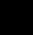

Accuracy = 1.000000, Time = 46.502779 sec
Slope = 0.010752
Accuracy = 1.000000, Time = 46.561409 sec
Slope = 0.010739
Accuracy = 1.000000, Time = 46.615838 sec
Slope = 0.010726
Accuracy = 1.000000, Time = 46.672224 sec
Slope = 0.010713
Accuracy = 1.000000, Time = 46.728263 sec
Slope = 0.010700
Accuracy = 1.000000, Time = 46.785094 sec
Slope = 0.010687
Accuracy = 1.000000, Time = 46.840258 sec
Slope = 0.010675
Accuracy = 1.000000, Time = 46.907241 sec
Slope = 0.010659
Accuracy = 1.000000, Time = 46.962237 sec
Slope = 0.010647
Accuracy = 1.000000, Time = 47.026238 sec
Slope = 0.010632
Accuracy = 1.000000, Time = 47.082466 sec
Slope = 0.010620
Accuracy = 1.000000, Time = 47.143937 sec
Slope = 0.010606
Accuracy = 1.000000, Time = 47.205286 sec
Slope = 0.010592
Accuracy = 1.000000, Time = 47.269869 sec
Slope = 0.010578
Accuracy = 1.000000, Time = 47.327384 sec
Slope = 0.010565
Accuracy = 1.000000, Time = 47.383104 sec
Slope = 0.010552
Accuracy = 1.000000, Time = 47.449868 sec
Slope = 0.0105

Accuracy = 1.000000, Time = 53.875944 sec
Slope = 0.009281
Accuracy = 1.000000, Time = 53.935416 sec
Slope = 0.009270
Accuracy = 1.000000, Time = 53.996136 sec
Slope = 0.009260
Accuracy = 1.000000, Time = 54.061850 sec
Slope = 0.009249
Accuracy = 1.000000, Time = 54.123814 sec
Slope = 0.009238
Accuracy = 1.000000, Time = 54.182980 sec
Slope = 0.009228
Accuracy = 1.000000, Time = 54.243646 sec
Slope = 0.009218
Accuracy = 1.000000, Time = 54.306930 sec
Slope = 0.009207
Accuracy = 1.000000, Time = 54.369885 sec
Slope = 0.009196
Accuracy = 1.000000, Time = 54.428000 sec
Slope = 0.009186
Accuracy = 1.000000, Time = 54.486247 sec
Slope = 0.009177
Accuracy = 1.000000, Time = 54.556029 sec
Slope = 0.009165
Accuracy = 1.000000, Time = 54.621830 sec
Slope = 0.009154
Accuracy = 1.000000, Time = 54.682416 sec
Slope = 0.009144
Accuracy = 1.000000, Time = 54.739048 sec
Slope = 0.009134
Accuracy = 1.000000, Time = 54.801118 sec
Slope = 0.009124
Accuracy = 1.000000, Time = 54.869147 sec
Slope = 0.0091

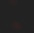

Accuracy = 1.000000, Time = 59.973936 sec
Slope = 0.008337
Accuracy = 1.000000, Time = 60.035286 sec
Slope = 0.008328
Accuracy = 1.000000, Time = 60.098243 sec
Slope = 0.008320
Accuracy = 1.000000, Time = 60.170363 sec
Slope = 0.008310
Accuracy = 1.000000, Time = 60.241447 sec
Slope = 0.008300
Accuracy = 1.000000, Time = 60.306125 sec
Slope = 0.008291
Accuracy = 1.000000, Time = 60.370206 sec
Slope = 0.008282
Accuracy = 1.000000, Time = 60.437639 sec
Slope = 0.008273
Accuracy = 1.000000, Time = 60.504015 sec
Slope = 0.008264
Accuracy = 1.000000, Time = 60.573015 sec
Slope = 0.008255
Accuracy = 1.000000, Time = 60.638369 sec
Slope = 0.008246
Accuracy = 1.000000, Time = 60.718572 sec
Slope = 0.008235
Accuracy = 1.000000, Time = 60.783217 sec
Slope = 0.008226
Accuracy = 1.000000, Time = 60.847284 sec
Slope = 0.008217
Accuracy = 1.000000, Time = 60.907740 sec
Slope = 0.008209
Accuracy = 1.000000, Time = 60.980076 sec
Slope = 0.008199
Accuracy = 1.000000, Time = 61.051408 sec
Slope = 0.0081

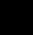

Accuracy = 1.000000, Time = 69.080244 sec
Slope = 0.007238
Accuracy = 1.000000, Time = 69.147225 sec
Slope = 0.007231
Accuracy = 1.000000, Time = 69.211717 sec
Slope = 0.007224
Accuracy = 1.000000, Time = 69.288814 sec
Slope = 0.007216
Accuracy = 1.000000, Time = 69.358603 sec
Slope = 0.007209
Accuracy = 1.000000, Time = 69.427097 sec
Slope = 0.007202
Accuracy = 1.000000, Time = 69.494346 sec
Slope = 0.007195
Accuracy = 1.000000, Time = 69.574903 sec
Slope = 0.007186
1700
Accuracy = 1.000000, Time = 69.649533 sec
Slope = 0.007179
Accuracy = 1.000000, Time = 69.717315 sec
Slope = 0.007172
Accuracy = 1.000000, Time = 69.786588 sec
Slope = 0.007165
Accuracy = 1.000000, Time = 69.862498 sec
Slope = 0.007157
Accuracy = 1.000000, Time = 69.929800 sec
Slope = 0.007150
Accuracy = 1.000000, Time = 69.996553 sec
Slope = 0.007143
Accuracy = 1.000000, Time = 70.067755 sec
Slope = 0.007136
Accuracy = 1.000000, Time = 70.135249 sec
Slope = 0.007129
Accuracy = 1.000000, Time = 70.209445 sec
Slope = 0

Accuracy = 1.000000, Time = 75.702728 sec
Slope = 0.006605
Accuracy = 1.000000, Time = 75.776461 sec
Slope = 0.006598
Accuracy = 1.000000, Time = 75.849175 sec
Slope = 0.006592
Accuracy = 1.000000, Time = 75.923368 sec
Slope = 0.006586
Accuracy = 1.000000, Time = 75.994176 sec
Slope = 0.006579
Accuracy = 1.000000, Time = 76.070233 sec
Slope = 0.006573
Accuracy = 1.000000, Time = 76.145233 sec
Slope = 0.006566
Accuracy = 1.000000, Time = 76.219002 sec
Slope = 0.006560
Accuracy = 1.000000, Time = 76.291216 sec
Slope = 0.006554
Accuracy = 1.000000, Time = 76.365061 sec
Slope = 0.006547
Accuracy = 1.000000, Time = 76.434389 sec
Slope = 0.006542
Accuracy = 1.000000, Time = 76.508730 sec
Slope = 0.006535
Accuracy = 1.000000, Time = 76.580857 sec
Slope = 0.006529
Accuracy = 1.000000, Time = 76.661969 sec
Slope = 0.006522
Accuracy = 1.000000, Time = 76.735103 sec
Slope = 0.006516
Accuracy = 1.000000, Time = 76.809535 sec
Slope = 0.006510
Accuracy = 1.000000, Time = 76.890497 sec
Slope = 0.0065

Accuracy = 1.000000, Time = 86.559561 sec
Slope = 0.005776
Accuracy = 1.000000, Time = 86.640172 sec
Slope = 0.005771
Accuracy = 1.000000, Time = 86.727043 sec
Slope = 0.005765
Accuracy = 1.000000, Time = 86.814812 sec
Slope = 0.005759
Accuracy = 1.000000, Time = 86.900990 sec
Slope = 0.005754
Accuracy = 1.000000, Time = 86.977108 sec
Slope = 0.005749
Accuracy = 1.000000, Time = 87.054326 sec
Slope = 0.005744
Accuracy = 1.000000, Time = 87.133620 sec
Slope = 0.005738
Accuracy = 1.000000, Time = 87.210363 sec
Slope = 0.005733
Accuracy = 1.000000, Time = 87.288708 sec
Slope = 0.005728
Accuracy = 1.000000, Time = 87.371958 sec
Slope = 0.005723
Accuracy = 1.000000, Time = 87.450875 sec
Slope = 0.005717
Accuracy = 1.000000, Time = 87.542809 sec
Slope = 0.005711
Accuracy = 1.000000, Time = 87.620237 sec
Slope = 0.005706
Accuracy = 1.000000, Time = 87.697523 sec
Slope = 0.005701
Accuracy = 1.000000, Time = 87.776295 sec
Slope = 0.005696
Accuracy = 1.000000, Time = 87.861777 sec
Slope = 0.0056

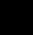

Accuracy = 1.000000, Time = 95.381128 sec
Slope = 0.005242
Accuracy = 1.000000, Time = 95.469644 sec
Slope = 0.005237
Accuracy = 1.000000, Time = 95.549325 sec
Slope = 0.005233
Accuracy = 1.000000, Time = 95.635952 sec
Slope = 0.005228
Accuracy = 1.000000, Time = 95.722467 sec
Slope = 0.005223
Accuracy = 1.000000, Time = 95.803065 sec
Slope = 0.005219
Accuracy = 1.000000, Time = 95.883812 sec
Slope = 0.005215
Accuracy = 1.000000, Time = 95.973895 sec
Slope = 0.005210
Accuracy = 1.000000, Time = 96.052362 sec
Slope = 0.005205
Accuracy = 1.000000, Time = 96.133504 sec
Slope = 0.005201
Accuracy = 1.000000, Time = 96.226099 sec
Slope = 0.005196
Accuracy = 1.000000, Time = 96.306869 sec
Slope = 0.005192
Accuracy = 1.000000, Time = 96.388165 sec
Slope = 0.005187
Accuracy = 1.000000, Time = 96.474821 sec
Slope = 0.005183
Accuracy = 1.000000, Time = 96.555270 sec
Slope = 0.005178
Accuracy = 1.000000, Time = 96.636850 sec
Slope = 0.005174
Accuracy = 1.000000, Time = 96.724865 sec
Slope = 0.0051

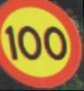

Accuracy = 1.000000, Time = 98.272925 sec
Slope = 0.005088
Accuracy = 1.000000, Time = 98.356830 sec
Slope = 0.005084
Accuracy = 1.000000, Time = 98.445413 sec
Slope = 0.005079
Accuracy = 1.000000, Time = 98.536652 sec
Slope = 0.005074
Accuracy = 1.000000, Time = 98.621099 sec
Slope = 0.005070
Accuracy = 1.000000, Time = 98.709675 sec
Slope = 0.005065
Accuracy = 1.000000, Time = 98.796374 sec
Slope = 0.005061
Accuracy = 1.000000, Time = 98.877227 sec
Slope = 0.005057
Accuracy = 1.000000, Time = 98.971165 sec
Slope = 0.005052
Accuracy = 1.000000, Time = 99.054886 sec
Slope = 0.005048
Accuracy = 1.000000, Time = 99.136044 sec
Slope = 0.005044
Accuracy = 1.000000, Time = 99.221330 sec
Slope = 0.005039
Accuracy = 1.000000, Time = 99.310748 sec
Slope = 0.005035
Accuracy = 1.000000, Time = 99.391934 sec
Slope = 0.005031
Accuracy = 1.000000, Time = 99.480121 sec
Slope = 0.005026
Accuracy = 1.000000, Time = 99.563903 sec
Slope = 0.005022
Accuracy = 1.000000, Time = 99.646486 sec
Slope = 0.0050

Accuracy = 1.000000, Time = 104.135616 sec
Slope = 0.004801
Accuracy = 1.000000, Time = 104.218213 sec
Slope = 0.004798
Accuracy = 1.000000, Time = 104.301351 sec
Slope = 0.004794
Accuracy = 1.000000, Time = 104.395076 sec
Slope = 0.004789
Accuracy = 1.000000, Time = 104.480865 sec
Slope = 0.004786
Accuracy = 1.000000, Time = 104.565856 sec
Slope = 0.004782
Accuracy = 1.000000, Time = 104.658151 sec
Slope = 0.004777
Accuracy = 1.000000, Time = 104.754368 sec
Slope = 0.004773
Accuracy = 1.000000, Time = 104.838503 sec
Slope = 0.004769
Accuracy = 1.000000, Time = 104.932511 sec
Slope = 0.004765
Accuracy = 1.000000, Time = 105.023724 sec
Slope = 0.004761
Accuracy = 1.000000, Time = 105.108895 sec
Slope = 0.004757
Accuracy = 1.000000, Time = 105.196995 sec
Slope = 0.004753
Accuracy = 1.000000, Time = 105.284014 sec
Slope = 0.004749
Accuracy = 1.000000, Time = 105.367361 sec
Slope = 0.004745
Accuracy = 1.000000, Time = 105.454743 sec
Slope = 0.004741
Accuracy = 1.000000, Time = 105.541861 s

Accuracy = 1.000000, Time = 106.363376 sec
Slope = 0.004701
Accuracy = 1.000000, Time = 106.447885 sec
Slope = 0.004697
Accuracy = 1.000000, Time = 106.535840 sec
Slope = 0.004693
Accuracy = 1.000000, Time = 106.622686 sec
Slope = 0.004689
Accuracy = 1.000000, Time = 106.708743 sec
Slope = 0.004686
Accuracy = 1.000000, Time = 106.799182 sec
Slope = 0.004682
Accuracy = 1.000000, Time = 106.888910 sec
Slope = 0.004678
Accuracy = 1.000000, Time = 106.973061 sec
Slope = 0.004674
Accuracy = 1.000000, Time = 107.059819 sec
Slope = 0.004670
Accuracy = 1.000000, Time = 107.153502 sec
Slope = 0.004666
Accuracy = 1.000000, Time = 107.243837 sec
Slope = 0.004662
Accuracy = 1.000000, Time = 107.330455 sec
Slope = 0.004659
Accuracy = 1.000000, Time = 107.415673 sec
Slope = 0.004655
Accuracy = 1.000000, Time = 107.501717 sec
Slope = 0.004651
Accuracy = 1.000000, Time = 107.596304 sec
Slope = 0.004647
Accuracy = 1.000000, Time = 107.685632 sec
Slope = 0.004643
Accuracy = 1.000000, Time = 107.767568 s

Accuracy = 1.000000, Time = 117.338258 sec
Slope = 0.004261
Accuracy = 1.000000, Time = 117.424658 sec
Slope = 0.004258
Accuracy = 1.000000, Time = 117.518745 sec
Slope = 0.004255
Accuracy = 1.000000, Time = 117.608462 sec
Slope = 0.004251
Accuracy = 1.000000, Time = 117.697450 sec
Slope = 0.004248
Accuracy = 1.000000, Time = 117.789256 sec
Slope = 0.004245
Actual: 120_SIGN, predicted: 60_SIGN


Accuracy = 1.000000, Time = 117.891950 sec
Slope = 0.004241
Accuracy = 1.000000, Time = 117.978011 sec
Slope = 0.004238
Accuracy = 1.000000, Time = 118.069179 sec
Slope = 0.004235
Accuracy = 1.000000, Time = 118.165665 sec
Slope = 0.004231
Accuracy = 1.000000, Time = 118.252862 sec
Slope = 0.004228
Accuracy = 1.000000, Time = 118.344851 sec
Slope = 0.004225
Accuracy = 1.000000, Time = 118.433159 sec
Slope = 0.004222
Accuracy = 1.000000, Time = 118.521934 sec
Slope = 0.004219
Accuracy = 1.000000, Time = 118.619080 sec
Slope = 0.004215
Accuracy = 1.000000, Time = 118.709409 sec
Slope = 0.004212
Accuracy = 1.000000, Time = 118.794753 sec
Slope = 0.004209
Accuracy = 1.000000, Time = 118.886547 sec
Slope = 0.004206
Accuracy = 1.000000, Time = 118.983739 sec
Slope = 0.004202
Accuracy = 1.000000, Time = 119.072273 sec
Slope = 0.004199
Accuracy = 1.000000, Time = 119.173136 sec
Slope = 0.004196
Accuracy = 1.000000, Time = 119.270877 sec
Slope = 0.004192
Accuracy = 1.000000, Time = 119.359097 s

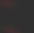

Accuracy = 1.000000, Time = 119.905659 sec
Slope = 0.004170
Accuracy = 1.000000, Time = 119.996405 sec
Slope = 0.004167
Accuracy = 1.000000, Time = 120.091842 sec
Slope = 0.004163
2300
Accuracy = 1.000000, Time = 120.180332 sec
Slope = 0.004160
Accuracy = 1.000000, Time = 120.277734 sec
Slope = 0.004157
Accuracy = 1.000000, Time = 120.369161 sec
Slope = 0.004154
Accuracy = 1.000000, Time = 120.461169 sec
Slope = 0.004151
Accuracy = 1.000000, Time = 120.572703 sec
Slope = 0.004147
Accuracy = 1.000000, Time = 120.658942 sec
Slope = 0.004144
Accuracy = 1.000000, Time = 120.760325 sec
Slope = 0.004140
Accuracy = 1.000000, Time = 120.863931 sec
Slope = 0.004137
Accuracy = 1.000000, Time = 120.951785 sec
Slope = 0.004134
Accuracy = 1.000000, Time = 121.053431 sec
Slope = 0.004130
Accuracy = 1.000000, Time = 121.150333 sec
Slope = 0.004127
Accuracy = 1.000000, Time = 121.237091 sec
Slope = 0.004124
Accuracy = 1.000000, Time = 121.330979 sec
Slope = 0.004121
Accuracy = 1.000000, Time = 121.424

Accuracy = 1.000000, Time = 125.672365 sec
Slope = 0.003979
Accuracy = 1.000000, Time = 125.780674 sec
Slope = 0.003975
Accuracy = 1.000000, Time = 125.876589 sec
Slope = 0.003972
Accuracy = 1.000000, Time = 125.976532 sec
Slope = 0.003969
Accuracy = 1.000000, Time = 126.074584 sec
Slope = 0.003966
Accuracy = 1.000000, Time = 126.176528 sec
Slope = 0.003963
Accuracy = 1.000000, Time = 126.267386 sec
Slope = 0.003960
Accuracy = 1.000000, Time = 126.361414 sec
Slope = 0.003957
Accuracy = 1.000000, Time = 126.450787 sec
Slope = 0.003954
Accuracy = 1.000000, Time = 126.544917 sec
Slope = 0.003951
Accuracy = 1.000000, Time = 126.634834 sec
Slope = 0.003948
Accuracy = 1.000000, Time = 126.729851 sec
Slope = 0.003945
Accuracy = 1.000000, Time = 126.836390 sec
Slope = 0.003942
Accuracy = 1.000000, Time = 126.933540 sec
Slope = 0.003939
Accuracy = 1.000000, Time = 127.025994 sec
Slope = 0.003936
Accuracy = 1.000000, Time = 127.129040 sec
Slope = 0.003933
Accuracy = 1.000000, Time = 127.234773 s

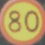

Accuracy = 1.000000, Time = 135.490465 sec
Slope = 0.003690
Accuracy = 1.000000, Time = 135.594254 sec
Slope = 0.003687
Accuracy = 1.000000, Time = 135.703131 sec
Slope = 0.003685
Accuracy = 1.000000, Time = 135.816278 sec
Slope = 0.003681
Accuracy = 1.000000, Time = 135.919749 sec
Slope = 0.003679
Accuracy = 1.000000, Time = 136.019147 sec
Slope = 0.003676
Accuracy = 1.000000, Time = 136.131263 sec
Slope = 0.003673
Accuracy = 1.000000, Time = 136.228047 sec
Slope = 0.003670
Accuracy = 1.000000, Time = 136.347729 sec
Slope = 0.003667
Accuracy = 1.000000, Time = 136.458179 sec
Slope = 0.003664
Accuracy = 1.000000, Time = 136.561054 sec
Slope = 0.003661
Accuracy = 1.000000, Time = 136.669623 sec
Slope = 0.003658
Accuracy = 1.000000, Time = 136.774747 sec
Slope = 0.003656
Accuracy = 1.000000, Time = 136.871923 sec
Slope = 0.003653
Accuracy = 1.000000, Time = 136.977265 sec
Slope = 0.003650
Accuracy = 1.000000, Time = 137.079195 sec
Slope = 0.003648
Accuracy = 1.000000, Time = 137.188541 s

In [ ]:
zipped_x_y = list(zip(test_x, test_y))
conf_true = []
conf_pred = []
conf_true = []
conf_pred = []
total_count = 0
correct_count = 0

start = time.time()

for tt in range(0, len(zipped_x_y)):
    q = zipped_x_y[tt]
    sfmax = list(sess.run(tf.nn.softmax(y.eval(feed_dict={x: [q[0]]})))[0])
    sf_ind = sfmax.index(max(sfmax))
    
    predicted_label = image_types[sf_ind]
    actual_label = image_types[q[1].index(max(q[1]))]
    
    conf_true.append(actual_label)
    conf_pred.append(predicted_label)
    if predicted_label == actual_label:
        correct_count = correct_count + 1

        total_count = total_count + 1
    if total_count % 100 == 0:
        print(total_count)

    end = time.time()
    accuracy = correct_count / total_count
    timeTaken = end - start
    print("Accuracy = %.6f, Time = %.6f sec" % (accuracy, timeTaken))
    print("Slope = %.6f" % ((accuracy - 0.5) / timeTaken))
    if predicted_label != actual_label:
        print("Actual: {}, predicted: {}".format(actual_label, predicted_label))
        img_path = test_z[tt]    
        ex_img = Image(filename=img_path)
        display(ex_img)

In [ ]:
# From sklearn docs
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    cm2 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cm2 = np.around(cm2, 2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(cm[i, j]) + " / " + str(cm2[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(conf_true, conf_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=image_types, normalize=False,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
argmax_prediction = tf.argmax(conf_pred, 1)
argmax_y = tf.argmax(conf_true, 1)

TP = tf.count_nonzero(argmax_prediction * argmax_y, dtype=tf.float32)
TN = tf.count_nonzero((argmax_prediction - 1) * (argmax_y - 1), dtype=tf.float32)
FP = tf.count_nonzero(argmax_prediction * (argmax_y - 1), dtype=tf.float32)
FN = tf.count_nonzero((argmax_prediction - 1) * argmax_y, dtype=tf.float32)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)

print(precision)
print(precision)